In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import tensorflow as tf
import math


In [4]:
filenames = os.listdir("train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.11229.jpg,0
1,cat.1123.jpg,0
2,cat.11230.jpg,0
3,cat.11231.jpg,0
4,cat.11232.jpg,0


<Axes: xlabel='category'>

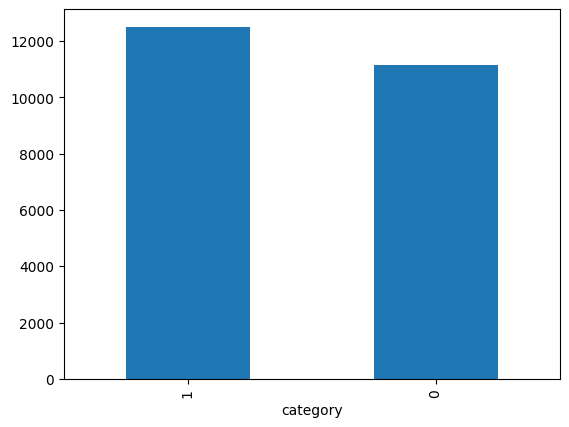

In [5]:
df['category'].value_counts().plot.bar()

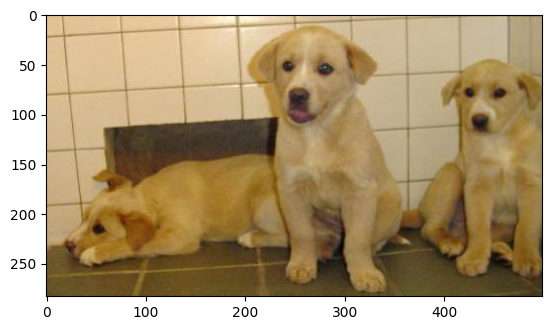

In [11]:
sample = random.choice(filenames)

# Assuming the images are in the "train" directory
image_path = os.path.join("train", sample)

# Load the image
image = load_img(image_path)

# Display the image
plt.imshow(image)
plt.show()

In [12]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [14]:
train_df['category'] = train_df['category'].astype(str)

# Create an ImageDataGenerator with appropriate augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Create a generator using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 21267 validated image filenames belonging to 2 classes.


In [15]:
validate_df['category'] = validate_df['category'].astype(str)

# Create an ImageDataGenerator with appropriate rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator using flow_from_dataframe for validation
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2364 validated image filenames belonging to 2 classes.


In [16]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_df['category'] = 'Other'

# Create an ImageDataGenerator with appropriate augmentation settings
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

Found 1 validated image filenames belonging to 1 classes.


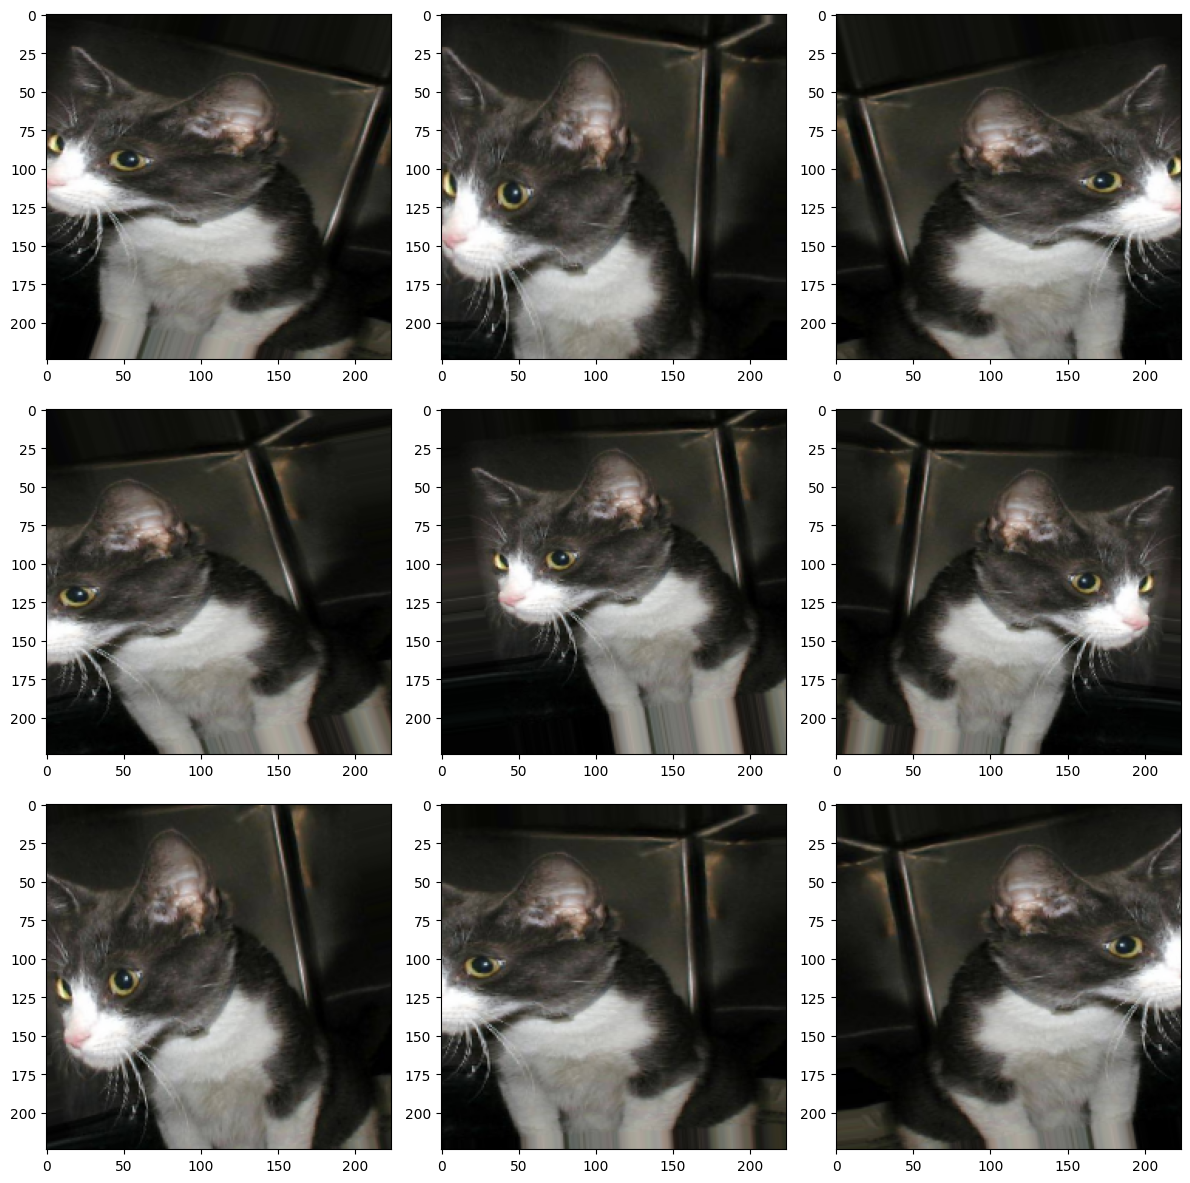

In [17]:
# Create a generator using flow_from_dataframe with class_mode='categorical'
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "train",
    x_col='filename',
    y_col='category',
    class_mode='categorical',  # Use categorical classification
    target_size=(image_size, image_size),
    batch_size=batch_size
)

# Create a subplot grid to display augmented images
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [18]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
    )

C:\Users\belim\AppData\Local\Temp\ipykernel_14996\464902123.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5



1329/1329 [==============================] - 2498s 2s/step - loss: 0.2400 - accuracy: 0.8930 - val_loss: 0.1078 - val_accuracy: 0.9558
Epoch 2/5
1329/1329 [==============================] - 39206s 30s/step - loss: 0.1367 - accuracy: 0.9436 - val_loss: 0.1394 - val_accuracy: 0.9303
Epoch 3/5
1329/1329 [==============================] - 3142s 2s/step - loss: 0.1156 - accuracy: 0.9546 - val_loss: 0.0843 - val_accuracy: 0.9651
Epoch 4/5
1329/1329 [==============================] - 30495s 23s/step - loss: 0.1035 - accuracy: 0.9600 - val_loss: 0.0647 - val_accuracy: 0.9736
Epoch 5/5
1329/1329 [==============================] - 3289s 2s/step - loss: 0.0876 - accuracy: 0.9668 - val_loss: 0.0878 - val_accuracy: 0.9673


In [19]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))


C:\Users\belim\AppData\Local\Temp\ipykernel_14996\2345088768.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.967262  ;  loss = 0.087840 


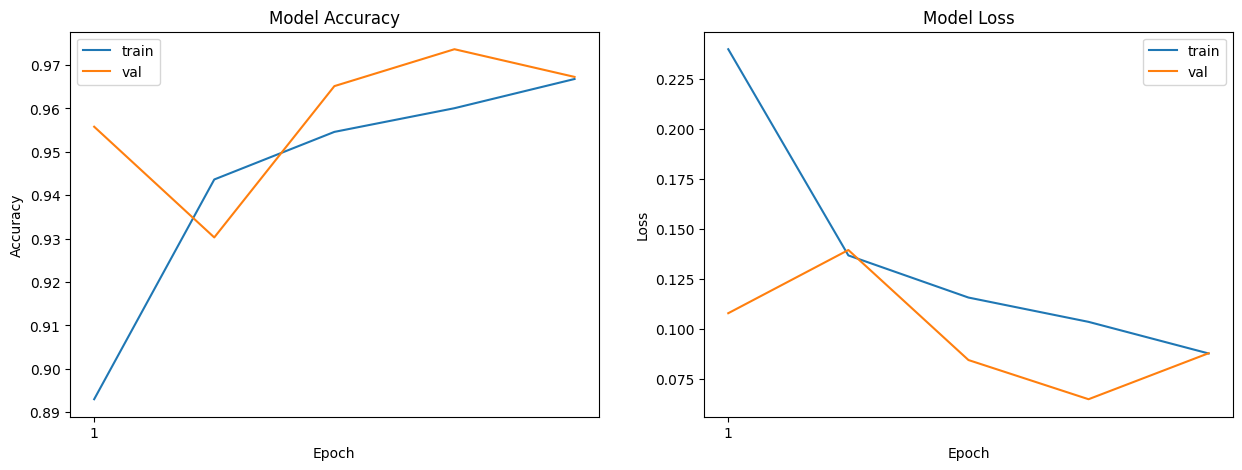

In [20]:

def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    
    # Set custom x-ticks at intervals of 10
    x_ticks = np.arange(1, len(model_history.history[acc]) + 1, 10)
    axs[0].set_xticks(x_ticks)
    
    axs[0].legend(['train', 'val'], loc='best')
    
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    
    # Set custom x-ticks at intervals of 10
    x_ticks = np.arange(1, len(model_history.history['loss']) + 1, 10)
    axs[1].set_xticks(x_ticks)
    
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

# Assuming you have a model history object with accuracy and loss recorded
plot_model_history(history, acc='accuracy', val_acc='val_accuracy')

In [21]:
Y_val = validate_df['category']
y_pred = model.predict(validation_generator)
threshold = 0.5
y_final = np.where(y_pred > threshold, 1, 0)
y_final.size

148/148 [==============================] - 307s 2s/step


2364

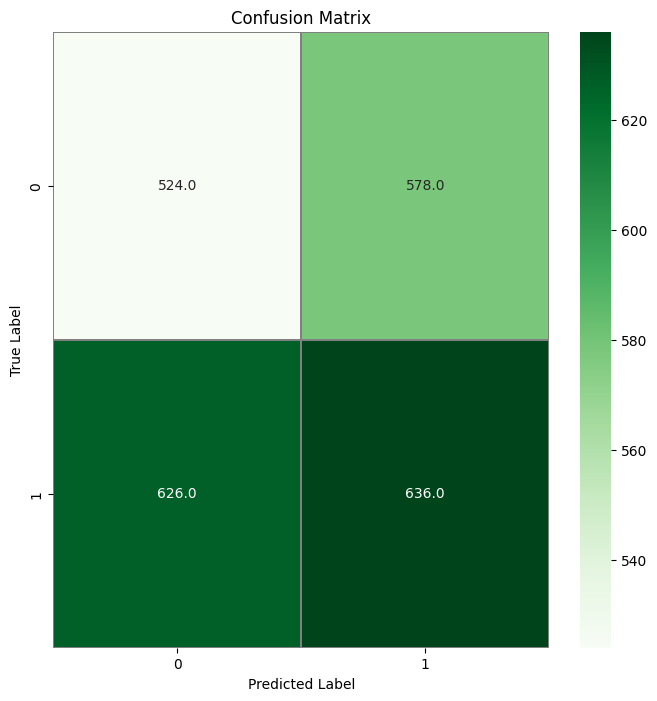

In [22]:
# Convert Y_val to integer data type
Y_val = Y_val.astype(int)

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 

# plot the confusion matrix
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Generate a classification report

In [23]:
report = classification_report(Y_val, y_final, target_names=['0','1'])
print(report)

              precision    recall  f1-score   support

           0       0.46      0.48      0.47      1102
           1       0.52      0.50      0.51      1262

    accuracy                           0.49      2364
   macro avg       0.49      0.49      0.49      2364
weighted avg       0.49      0.49      0.49      2364



In [24]:
test_filenames = os.listdir("test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [25]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


In [26]:
predictions = model.predict(test_generator)

# Assuming 'threshold' is your desired classification threshold
threshold = 0.5

# Applying the threshold to convert probabilities to binary predictions
test_df['category'] = np.where(predictions > threshold, 1, 0)

782/782 [==============================] - 1481s 2s/step


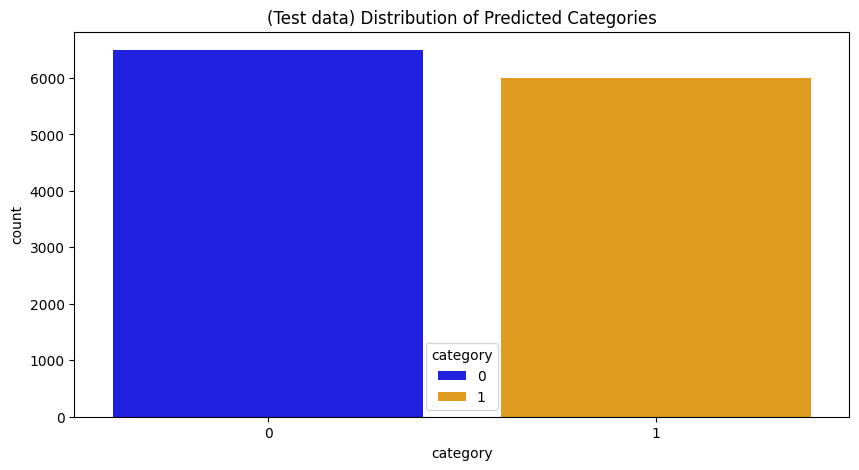

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
sns.countplot(x='category', data=test_df, hue='category', palette={0: 'blue', 1: 'orange'})
plt.title("(Test data) Distribution of Predicted Categories")
plt.show()


In [28]:
import pandas as pd

# 'test_df' has the 'filename' and 'category' columns
# 'predictions' is the array of predicted probabilities
threshold = 0.5
test_df['category'] = (predictions > threshold).astype(int)

# Create a DataFrame with 'filename' and 'category' columns
result_df = pd.DataFrame({'filename': test_df['filename'], 'category': test_df['category']})

# Save the DataFrame to a CSV file
result_df.to_csv('predictions.csv', index=False)


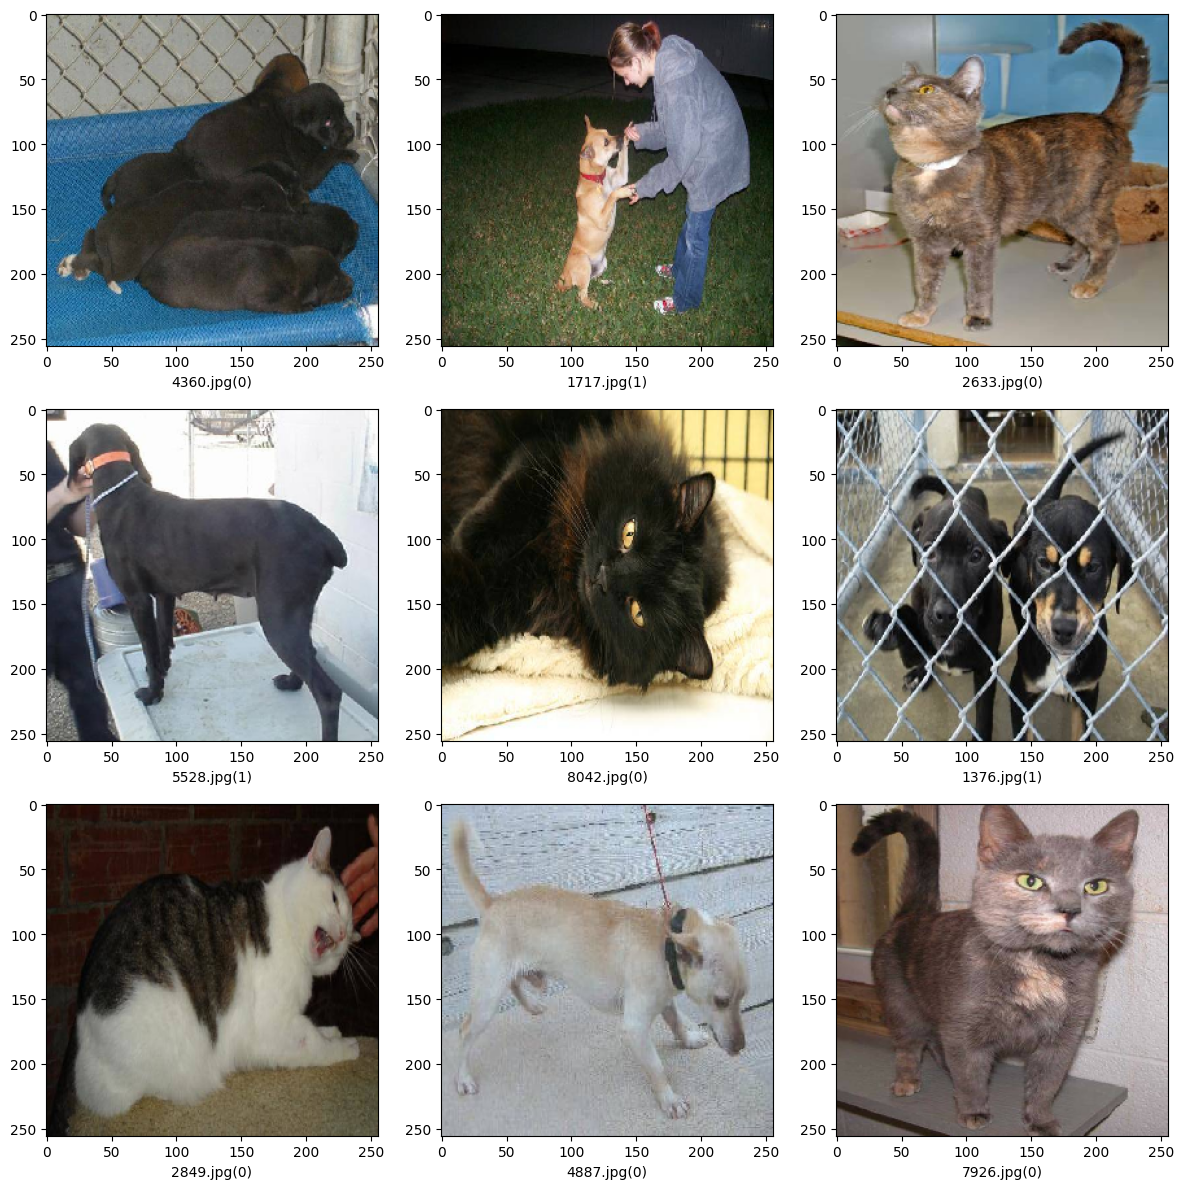

In [32]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [33]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=submission_df)
plt.title("(Test data)")

NameError: name 'submission_df' is not defined

<Figure size 1000x500 with 0 Axes>

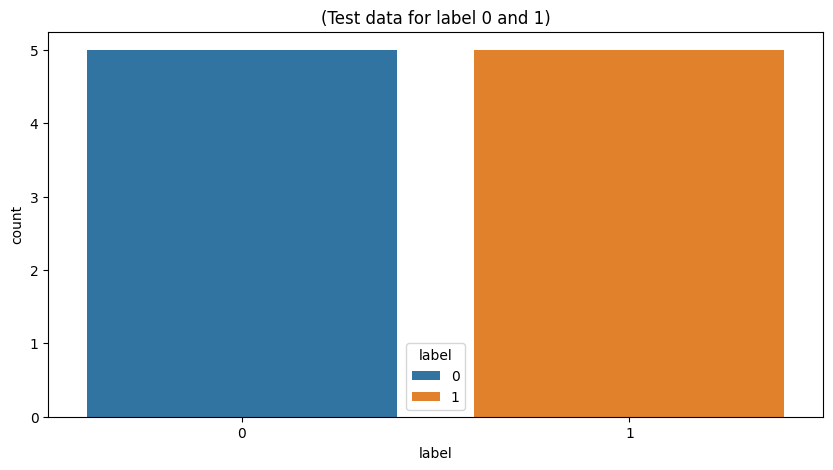

In [38]:
test_df = pd.DataFrame({'label': [0, 1, 0, 1, 0, 1, 1, 0, 0, 1]})

# Plot for both labels in the same plot
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=test_df, hue='label')
plt.title("(Test data for label 0 and 1)")
plt.show()
